# Fake News Project
The goal of this project is to create a fake news prediction system. Fake news is a major problem that can have serious negative effects on how people understand the world around them. You will work with a dataset containing real and fake news in order to train a simple and a more advanced classifier to solve this problem. This project covers the full Data Science pipeline, from data processing, to modelling, to visualization and interpretation.
## Part 1 Data Processing

### Task 1

In [ ]:
import pandas as pd 
df = pd.read_csv("news_sample.csv")
dfcpy = df.copy()
dfcpy = dfcpy.dropna(subset=['content'])

In [ ]:
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

In [ ]:
import re
import nltk
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from cleantext import clean


def clean_text(text):
  clean_text = re.sub(r'([A-Z][A-z]+.?) ([0-9]{1,2}?), ([0-9]{4})', '<DATE>', text)
  clean_text = clean(clean_text,
    lower=True,
    no_urls=True, replace_with_url="<URL>",
    no_emails=True, replace_with_email="<EMAIL>",
    no_numbers=True, replace_with_number= r"<NUM>",
    no_currency_symbols=True, replace_with_currency_symbol="<CUR>",
    no_punct=True, replace_with_punct="",
    no_line_breaks=True 
  )
  return clean_text

def rmv_stopwords(tokens):
  stop_words = set(nltk.corpus.stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]
  return tokens

def stem_tokens(tokens):
  stemmer=PorterStemmer()
  Output=[stemmer.stem(word) for word in tokens]
  return Output

# build a vocabulary from a dataframe with list of tokens
def build_vocabulary(df_tokens):
    # Flatten the list of tokens
  tokens = []
  for lst in df_tokens:
    tokens += lst
  fq = FreqDist(tokens)
  return fq

In [ ]:
dfcpy = df.copy()

dfcpy.content = dfcpy.content.apply(clean_text)

tokenizer = RegexpTokenizer(r'<[\w]+>|[\w]+')
dfcpy["tokenized"] = dfcpy.content.apply(tokenizer.tokenize)

vocab = build_vocabulary(dfcpy.tokenized)
vocab_size = vocab.B()
print("After cleaning:")
print(f"vocabulary size: {vocab_size}\n")

dfcpy.tokenized = dfcpy.tokenized.apply(rmv_stopwords)
vocab = build_vocabulary(dfcpy.tokenized)
# reduction rate of the vocabulary size
reduction = ((vocab_size - vocab.B())/vocab_size)*100
vocab_size = vocab.B()
print("After removing stopwords:")
print(f"vocabulary size: {vocab_size}")
print(f"reduction rate of the vocabulary size: {reduction:.2f}%\n")

dfcpy.tokenized = dfcpy.tokenized.apply(stem_tokens)
vocab = build_vocabulary(dfcpy.tokenized)
reduction = ((vocab_size - vocab.B())/vocab_size)*100
vocab_size = vocab.B()
print("After stemming:")
print(f"vocabulary size: {vocab_size}")
print(f"reduction rate of the vocabulary size: {reduction:.2f}%\n")


1. counting the number of URLs in the content
2. counting the number of dates in the content
3. counting the number of numeric values in the content
4. determining the 100 more frequent words that appear in the content
5. plot the frequency of the 10000 most frequent words (any interesting patterns?)
6. run the analysis in point 4 and 5 both before and after removing stopwords and applying stemming: do you see any difference?


In [ ]:
# pip install "modin[ray]"
# import modin.pandas as pd

In [ ]:
df = pd.read_csv("995,000_rows.csv", usecols=['content', 'type', 'url', 'title', 'authors', 'domain'], engine='c', dtype = str, nrows=70000)
dfcpy = df.copy()
dfcpy = dfcpy.dropna(subset=['content'])
dfcpy = dfcpy.dropna(subset=['type'])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot the frequency of the top n words
def plot_freq(fq, top_n):
  common_words = fq.most_common(top_n)
  # convert the list of tuples to a dictionary 
  all_freq = dict(common_words)
  # create a plot
  # plot most be less than 2^16 pixels in each direction
  plt.figure(figsize = (top_n*0.1, 5))
  plt.xticks(rotation = 90,fontsize = 5)
  plt.yticks(range(0, max(all_freq.values())+1, 50000))
  sns.lineplot(x = list(all_freq.keys()), y = list(all_freq.values()), color = 'red')
  sns.barplot(x = list(all_freq.keys()), y = list(all_freq.values()))
  plt.title(f'Top {top_n} most common words')
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.grid(axis = 'y')
  plt.show()
  return

In [ ]:
dfcpy.content = dfcpy.content.apply(clean_text)

In [ ]:
tokenizer = RegexpTokenizer(r'<[\w]+>|[\w]+')
dfcpy["tokenized"] = dfcpy.content.apply(tokenizer.tokenize)


In [ ]:
dfcpy.tokenized = dfcpy.tokenized.apply(rmv_stopwords)

In [ ]:
dfcpy.tokenized = dfcpy.tokenized.apply(stem_tokens)

In [ ]:
vocab = build_vocabulary(dfcpy.tokenized)

In [ ]:
dfcpy.to_csv('cleaned_news_sample.csv', index=False)

## Data exploration

In [ ]:
# make tokenize colum into a string with whitespace separator

# plot distrubution of types only for the top 10 types
# dfcpy.domain.value_counts().head(20).plot(kind='bar', figsize=(10,5), title='Domain distribution')

def plot_domain_with_type(df):
  # make stacked bar plot for the top 20 domains with their types where am
  top_domains = df.domain.value_counts().head(20).index
  df = df[df.domain.isin(top_domains)]
  df = df.groupby(['domain', 'type']).size().unstack().fillna(0)

  df.plot(kind='bar', stacked=True, figsize=(10,5), title='Domain distribution with types')
  plt.show()
  return

# domain distribution and their tyoes
plot_domain_with_type(dfcpy)

# most frequent words
dfcpy.tokenized = dfcpy.tokenized.apply(lambda x: ' '.join(x))
num_freq = vocab.get("<num>",0)
plot_freq(vocab, 100)



# Task 4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv('cleaned_news_sample.csv', usecols=['tokenized', 'type'], engine='c', dtype = str, nrows=70000)
dfcpy = df.copy()


# label is 1 if the article is fake, 0 if the article is reliable
dfcpy['label'] = dfcpy['type'].map({'fake': 1, 'conspiracy': 1, 'junksci': 1, 'bias': 1, 'clickbait': 0, 'political': 0, 'reliable': 0})
dfcpy = dfcpy.dropna(subset=['label'])
dfcpy['label'] = dfcpy['label'].astype(int)

X = dfcpy['tokenized']
y = dfcpy['label']
X.dropna(inplace=True)
y = y.loc[X.index]


train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state = 42) 
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size= test_ratio / (test_ratio + validation_ratio), random_state = 42)

print("Training Set:")
print(x_train.head())
x_train = x_train.apply(lambda x: np.str_(x))
x_val = x_val.apply(lambda x: np.str_(x))
x_test = x_test.apply(lambda x: np.str_(x))

Training Set:
11778    ['photo', 'reutersstring', 'resid', 'queue', '...
55781    ['final', 'came', 'get', 'told', 'happen', 'ha...
64465    ['intern', 'crimin', 'court', 'prosecutor', 'f...
33990    ['obama', 'back', 'savag', 'syria', 'jihadist'...
43838    ['australia', 'popular', 'choic', 'among', 'fa...
Name: tokenized, dtype: object


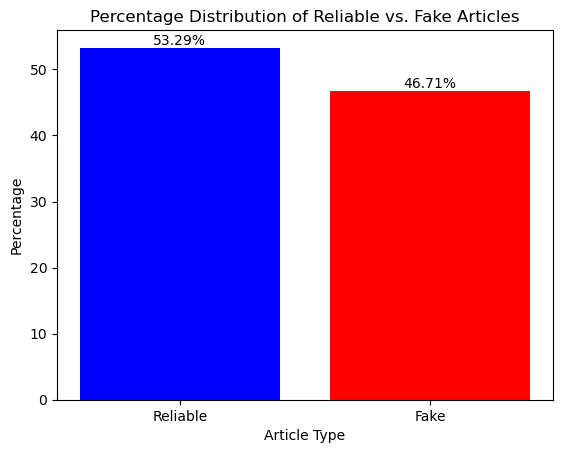

In [2]:
# Examine the percentage distribution of 'reliable' vs. 'fake' articles
grouped_type = dfcpy['label'].value_counts()
grouped_type = grouped_type / grouped_type.sum() * 100

# make a bar plot with percentages on bars
plt.bar([0, 1], grouped_type, tick_label=['Reliable', 'Fake'], color=['blue', 'red'])
plt.text(0, grouped_type[0], f'{grouped_type[0]:.2f}%', ha='center', va='bottom')
plt.text(1, grouped_type[1], f'{grouped_type[1]:.2f}%', ha='center', va='bottom')
plt.xlabel('Article Type')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Reliable vs. Fake Articles')
plt.show()

In [3]:
import sklearn.metrics as metrics
import seaborn as sns
def evaluate_model(y_val, y_pred):
    # Confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_val, y_pred, labels=[1, 0])
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['fake', 'real'], yticklabels=['fake', 'real'])

    # Classification report
    classification_report = metrics.classification_report(y_val, y_pred, target_names = ['fake', 'real'], zero_division=0)
    print(classification_report)
    accuracy = metrics.accuracy_score(y_val, y_pred)
    f1 = metrics.f1_score(y_val, y_pred)
    print("f1 score:", f1)
    print("accuracy:", accuracy)

# Part 2: A simple model

              precision    recall  f1-score   support

        fake       0.83      0.86      0.85      2970
        real       0.85      0.81      0.83      2748

    accuracy                           0.84      5718
   macro avg       0.84      0.83      0.84      5718
weighted avg       0.84      0.84      0.84      5718

f1 score: 0.8252608047690015
accuracy: 0.8359566281916754


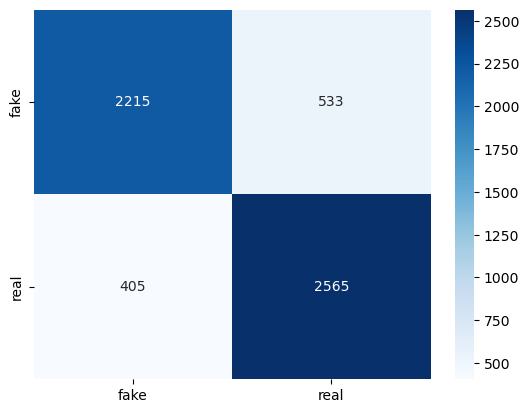

In [4]:
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# scaling the data
model = Pipeline([("tfidf", TfidfVectorizer()),
                ("scaler", StandardScaler(with_mean=False)), 
                ("log_reg", LogisticRegression(solver='sag',max_iter=10000))])
# prøv at sætte c lavere

model.fit(x_train, y_train)
y_pred = model.predict(x_val)
evaluate_model(y_val, y_pred)

# Part 3: Advanced model

3 models: 
- LinearSVM
- Naive bayes
- Random forrest

2 vector representations:
- TF-IDF, 3 grams
- Word embedding (word2vec)

We perfrom cross validation on hyper paramaters to find the best hyperparameters for each model 

## Vectorization

###  TF-IDF vectorizer

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(2, 2))),
    ('scaler', StandardScaler(with_mean=False))
    ])

X_train_TFIDF = pipeline.fit_transform(x_train, y_train) 
X_val_TFIDF = pipeline.transform(x_val)
X_test_TFIDF = pipeline.transform(x_test)


### Word2Vec

In [ ]:
# X_train_W2V = 
# X_val_W2V = 
# X_test_W2V = 

## Model 1: Linear SVC 

In [6]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
def svc_advanced(x_train, y_train, x_val):
    svc = LinearSVC(dual=True, max_iter=10000)
    parameters = dict(C = [0.01, 0.1, 1, 10, 100], loss = ['hinge', 'squared_hinge'], tol = [1e-4, 1e-3, 1])

    # Cross-validation
    grid_search = GridSearchCV(svc, parameters, cv=3, n_jobs=-1, scoring = 'f1')
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)
    
    return grid_search.predict(x_val)

### TF-IDF 

In [7]:
y_pred = svc_advanced(X_train_TFIDF, y_train, X_val_TFIDF)
evaluate_model(y_val, y_pred)

KeyboardInterrupt: 

### Word2vec

In [ ]:
y_pred = svc_advanced(X_train_W2V, y_train, X_val_W2V)
evaluate_model(y_val, y_pred)

## Model 2: Naive bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

def naive_bayes_advanced(x_train, y_train, x_val):
    nb = MultinomialNB()
    parameters = dict(alpha = [0.01, 0.1, 1, 10, 100])

    # Cross-validation
    grid_search = GridSearchCV(nb, parameters, cv=3, n_jobs=-1, scoring='f1')
    grid_search.fit(x_train, y_train)


    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)

    return grid_search.predict(x_val)

y_pred = naive_bayes_advanced(X_train_TFIDF, y_train, X_val_TFIDF)
evaluate_model(y_val, y_pred)

### TF-IDF

In [ ]:
y_pred = naive_bayes_advanced(X_train_TFIDF, y_train, X_val_TFIDF)
evaluate_model(y_val, y_pred)

### Word2Vec

In [ ]:
y_pred = naive_bayes_advanced(X_train_W2V, y_train, X_val_W2V)
evaluate_model(y_val, y_pred)

## Model 3: Random forrest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def random_forest_advanced(x_train, y_train, x_val):
    rf = RandomForestClassifier()
    parameters = dict(n_estimators = [100, 200, 300], 
                      max_depth = [10, 20, 30], 
                      min_samples_split = [2, 5, 10], 
                      min_samples_leaf = [1, 2, 4])

    # Cross-validation
    grid_search = GridSearchCV(rf, parameters, cv=3, n_jobs=-1, scoring='f1')
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)

    return grid_search.predict(x_val)

In [ ]:
# rf = RandomForestClassifier(random_state=42)

# pipeline_rf = Pipeline([
#     ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
#     ('rf', rf)
# ])


# param_grid = {
#     'rf__n_estimators': [100, 200, 300],  
#     'rf__max_depth': [10, 20, 30],  
# }

# # Cross-validation
# grid_search = GridSearchCV(pipeline_rf, param_grid, cv=5, n_jobs=-1, scoring='f1')
# grid_search.fit(x_train, y_train)

# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# y_pred = grid_search.predict(x_val)

### TF-IDF

In [ ]:
y_pred = random_forest_advanced(X_train_TFIDF, y_train, X_val_TFIDF)
evaluate_model(y_val, y_pred)

### Word2Vec

In [ ]:
y_pred = random_forest_advanced(X_train_W2V, y_train, X_val_W2V)
evaluate_model(y_val, y_pred)